# Imports

In [1]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import shap
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels
import spacy
import time
from tqdm import tqdm

# Data preprocessing

In [2]:
def replace_mentions(text):
    """
    Replaces twitter mentions in the given text by a contant tag.
    Returns the clean text.
    """
    MENTIONS_REPLACEMENT_TAG = "mention"
    MENTIONS_REGEXS = [
        r'(@ [\w\d-]+(( _)|(_ )|( _ )|_)+[\w\d-]+)', # something + _ + something
        r'(@ [\w\d-]+( [\d-]+))', # something + space + numbers
        r'(@ [\w\d-]+)', # something
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in MENTIONS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            mention = [mention for mention in tuple_matches if len(mention) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            mention = tuple_matches
        text = text.replace(mention, MENTIONS_REPLACEMENT_TAG)
    return text

In [3]:
def replace_hashtags(text):
    """
    Replaces twitter hashtags in the given text by a contant tag.
    Returns the clean text.
    """
    HASHTAGS_REPLACEMENT_TAG = "hashtag"
    HASHTAGS_REGEXS = [
        r'(# [\w\d_-]+( \d+)*)',
        r'(# [\w\d_-]+)',
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in HASHTAGS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            hashtag = [hashtag for hashtag in tuple_matches if len(hashtag) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            hashtag = tuple_matches
        text = text.replace(hashtag, HASHTAGS_REPLACEMENT_TAG)
    return text

In [4]:
def load_data():
    """
    Loads the data in a pandas' dataframe.
    Returns the dataframe containing following columns : 'author_id' (int), 'label' (int) and 'content' (str).
    """
    data = pd.DataFrame()
    data_files = ['./data/AMale.txt', './data/AFemale.txt']

    for data_file in data_files:
        data = data.append(pd.read_csv(data_file, sep="\t", header=None, encoding='latin-1'))

    data = data.drop(1, axis='columns') # drop profile's column (human/bot)
    data = data.rename(columns={0: 'author_id', 2: 'label', 3: 'content'})

    data['author_id'] = data['author_id'].apply(lambda x: int(x)) # ids should be integers
    data['label'] = data['label'].apply(lambda gender: 0 if gender == 'M' else 1) # male:0, female:1
    return data

In [5]:
def preprocess_data(data):
    """
    Applies preprocessing methods on the given dataframe.
    The dataframe must contain following columns :  'author_id' (int), 'label' (int) and 'content' (str).
    Returns the dataframe.
    """
    # text preprocessing
    data['content'] = data['content'].apply(replace_mentions)
    data['content'] = data['content'].apply(replace_hashtags)
    
    data['original_content'] = data['content'] # original content shouldn't be changed
    
    data['content'] = data['content'].apply(lambda content: content.lower())
    # emojis ?
    # concat tweets of same author ?
    # remove punctuation ?
    # remove stop-words
    # stemming / lemmatization
    
    return data

# Features

In [6]:
def compute_feature_nb_char(row, feature_name):
    """
    Computes the feature nb_character for the given row.
    Returns the row with the new feature.
    """
    row[feature_name] = [len(row['content'])]
    return row

In [7]:
def compute_row_features(row, features_dict):
    """
    Computes the features specified in the given dictionary for the given row.
    Returns the row with the new features.
    """
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            if feature_name == 'nb_characters':
                row = compute_feature_nb_char(row, feature_name)
            row['features'] = np.array([np.concatenate((v1, v2), axis=None) for v1, v2 in zip(row['features'], row[feature_name])]) if len(row['features']) > 0 else row[feature_name]
    return row

In [8]:
def compute_dataframe_features(data, features_dict):
    """
    Computes the features specified in the given dictionary for the whole dataframe.
    Returns the dataframe with the new features.
    """
    # create needed columns
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            data[feature_name] = np.NaN
    data['features'] = [[] for _ in np.arange(len(data))]
    # loop over the rows
    data = data.apply(lambda row: compute_row_features(row, features_dict), axis=1)
    return data

In [9]:
def scale_data(scaler, X_train, X_test):
    """
    Uses a Scikit-Learn scaler to scale the data.
    Returns the scaled X_train and X_test.
    """
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Classification

In [10]:
def train_model(classifier, X_train, y_train, X_test, y_test, params, pot_confusion_matrix=True):
    """
    Initializes an instance of the given classification model with its parameters.
    Trains and evaluates the classifier before returning it with the classification scores.
    """
    model = classifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred, average=None), 
              recall_score(y_test, y_pred, average=None)]
    if pot_confusion_matrix:
        plot_confusion_matrix(y_test, y_pred, np.array(['Man', 'Woman']))
    return model, scores

In [11]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Data visualization

In [12]:
def plot_data(X, y):
    """
    Uses t-SNE to plot an approximation of the data projected in 2d.
    """
    X_embedded = TSNE(n_components=2).fit_transform(X)
    category_to_color = {0: 'cyan', 1: 'magenta'}
    category_to_label = {0: 'Man', 1: 'Woman'}
    
    plt.figure(figsize=(10,10))
    for category in category_to_color.keys():
        plt_x = [X_embedded[i,0] for i, cat in enumerate(y) if cat == category]
        plt_y = [X_embedded[i,1] for i, cat in enumerate(y) if cat == category]
        plt.scatter(plt_x, plt_y, color=category_to_color[category], label=category_to_label[category], alpha=0.6)
        plt.legend(loc='best')
    plt.title('Corpus entries\' visualization')
    plt.show()

# Constants

In [66]:
# define constants here...

# features
features = {
    'nb_characters': True,
    'nb_tokens': False,
    'nb_big_words': False,
    'nb_lexical_words': False,
}

# models
CLASSIFIER = CatBoostClassifier # [CatBoostClassifier]
SCALER = StandardScaler # [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]

# models' parameters
PARAMS = {
    CatBoostClassifier: {
        'iterations':200, 
        'depth':6, 
        'learning_rate':0.2, 
        'loss_function':'CrossEntropy', 
        'custom_metric':['Accuracy', 'Recall', 'Precision'], 
        'verbose':False},
}
GRIDSEARCH_PARAMS_RANGE = {
    CatBoostClassifier: {
        'loss_function': ['Logloss', 'CrossEntropy'],
        'iterations': [250,100,500,1000],
        'depth': [3,1,2,6,4,5,7,8,9,10],
        'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3], 
    }
}

# training
NB_CV_SPLITS = 5
GRIDSEARCH_NB_CV_SPLITS = 2
TEST_SIZE = 0.2
PLOT_TRAINING_DATA = False

# ---- constants' validity check
assert NB_CV_SPLITS > 0
assert GRIDSEARCH_NB_CV_SPLITS > 1
assert CLASSIFIER in [CatBoostClassifier]
assert SCALER in [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]
assert TEST_SIZE > 0.0 and TEST_SIZE < 1.0

# Main

In [14]:
data = load_data()
data = preprocess_data(data)

In [15]:
data = compute_dataframe_features(data, features)
X, y = np.array(data['features'].tolist()), np.array(data['label'].tolist())

In [51]:
data[:2]

,author_id,label,content,original_content,nb_characters,features
0,6,0,mention ahaha last time acting reckless ðð,mention ahaha last time acting reckless ðð,[49],[49]
1,6,0,mention ahahaha i ' ve stopped lmao,mention ahahaha i ' ve stopped lmao,[36],[36]


In [21]:
# t-SNE (, Shap)
plot_data(X, y)

KeyboardInterrupt: 

In [65]:
# gridsearch
clf = GridSearchCV(CLASSIFIER(), GRIDSEARCH_PARAMS_RANGE[CLASSIFIER], cv=GRIDSEARCH_NB_CV_SPLITS)
clf.fit(X, y)
print(f'Best classification score: {clf.best_score_}')
print(f'Best parameters: {clf.best_params_}')

0:	learn: 0.6927380	total: 21.2ms	remaining: 4.22s
1:	learn: 0.6923528	total: 48.4ms	remaining: 4.79s
2:	learn: 0.6920545	total: 76.9ms	remaining: 5.05s
3:	learn: 0.6917772	total: 106ms	remaining: 5.17s
4:	learn: 0.6915815	total: 139ms	remaining: 5.42s
5:	learn: 0.6914132	total: 170ms	remaining: 5.5s
6:	learn: 0.6912568	total: 195ms	remaining: 5.38s
7:	learn: 0.6910916	total: 232ms	remaining: 5.57s
8:	learn: 0.6909915	total: 256ms	remaining: 5.42s
9:	learn: 0.6908739	total: 277ms	remaining: 5.26s
10:	learn: 0.6907698	total: 314ms	remaining: 5.39s
11:	learn: 0.6906867	total: 347ms	remaining: 5.43s
12:	learn: 0.6906103	total: 373ms	remaining: 5.36s
13:	learn: 0.6905093	total: 413ms	remaining: 5.49s
14:	learn: 0.6904623	total: 442ms	remaining: 5.46s
15:	learn: 0.6904055	total: 472ms	remaining: 5.43s
16:	learn: 0.6903627	total: 499ms	remaining: 5.38s
17:	learn: 0.6903346	total: 532ms	remaining: 5.38s
18:	learn: 0.6903083	total: 565ms	remaining: 5.38s
19:	learn: 0.6902884	total: 598ms	remai

161:	learn: 0.6897273	total: 4.73s	remaining: 1.11s
162:	learn: 0.6897250	total: 4.76s	remaining: 1.08s
163:	learn: 0.6897211	total: 4.79s	remaining: 1.05s
164:	learn: 0.6897210	total: 4.82s	remaining: 1.02s
165:	learn: 0.6897197	total: 4.85s	remaining: 994ms
166:	learn: 0.6897150	total: 4.88s	remaining: 964ms
167:	learn: 0.6897116	total: 4.91s	remaining: 935ms
168:	learn: 0.6897083	total: 4.94s	remaining: 906ms
169:	learn: 0.6897031	total: 4.97s	remaining: 877ms
170:	learn: 0.6896985	total: 5s	remaining: 848ms
171:	learn: 0.6896966	total: 5.04s	remaining: 821ms
172:	learn: 0.6896935	total: 5.07s	remaining: 791ms
173:	learn: 0.6896917	total: 5.11s	remaining: 763ms
174:	learn: 0.6896896	total: 5.14s	remaining: 734ms
175:	learn: 0.6896869	total: 5.17s	remaining: 705ms
176:	learn: 0.6896869	total: 5.2s	remaining: 675ms
177:	learn: 0.6896863	total: 5.23s	remaining: 646ms
178:	learn: 0.6896817	total: 5.25s	remaining: 617ms
179:	learn: 0.6896773	total: 5.28s	remaining: 587ms
180:	learn: 0.68

122:	learn: 0.6906657	total: 3.41s	remaining: 2.13s
123:	learn: 0.6906603	total: 3.43s	remaining: 2.1s
124:	learn: 0.6906600	total: 3.45s	remaining: 2.07s
125:	learn: 0.6906539	total: 3.48s	remaining: 2.04s
126:	learn: 0.6906507	total: 3.52s	remaining: 2.02s
127:	learn: 0.6906502	total: 3.54s	remaining: 1.99s
128:	learn: 0.6906433	total: 3.56s	remaining: 1.96s
129:	learn: 0.6906428	total: 3.59s	remaining: 1.93s
130:	learn: 0.6906428	total: 3.61s	remaining: 1.9s
131:	learn: 0.6906410	total: 3.63s	remaining: 1.87s
132:	learn: 0.6906407	total: 3.65s	remaining: 1.84s
133:	learn: 0.6906302	total: 3.68s	remaining: 1.81s
134:	learn: 0.6906298	total: 3.7s	remaining: 1.78s
135:	learn: 0.6906270	total: 3.73s	remaining: 1.75s
136:	learn: 0.6906211	total: 3.76s	remaining: 1.73s
137:	learn: 0.6906192	total: 3.79s	remaining: 1.7s
138:	learn: 0.6906163	total: 3.82s	remaining: 1.67s
139:	learn: 0.6906129	total: 3.84s	remaining: 1.65s
140:	learn: 0.6906113	total: 3.87s	remaining: 1.62s
141:	learn: 0.69

82:	learn: 0.6896899	total: 2.32s	remaining: 3.27s
83:	learn: 0.6896827	total: 2.34s	remaining: 3.23s
84:	learn: 0.6896822	total: 2.37s	remaining: 3.21s
85:	learn: 0.6896780	total: 2.4s	remaining: 3.19s
86:	learn: 0.6896584	total: 2.43s	remaining: 3.15s
87:	learn: 0.6896474	total: 2.46s	remaining: 3.13s
88:	learn: 0.6896447	total: 2.49s	remaining: 3.1s
89:	learn: 0.6896430	total: 2.52s	remaining: 3.07s
90:	learn: 0.6896352	total: 2.54s	remaining: 3.05s
91:	learn: 0.6896290	total: 2.58s	remaining: 3.03s
92:	learn: 0.6896192	total: 2.61s	remaining: 3.01s
93:	learn: 0.6896192	total: 2.64s	remaining: 2.98s
94:	learn: 0.6896171	total: 2.68s	remaining: 2.96s
95:	learn: 0.6896087	total: 2.71s	remaining: 2.94s
96:	learn: 0.6896062	total: 2.74s	remaining: 2.91s
97:	learn: 0.6896035	total: 2.79s	remaining: 2.9s
98:	learn: 0.6896031	total: 2.82s	remaining: 2.88s
99:	learn: 0.6895998	total: 2.85s	remaining: 2.85s
100:	learn: 0.6895960	total: 2.88s	remaining: 2.83s
101:	learn: 0.6895918	total: 2.91

42:	learn: 0.6907554	total: 1.11s	remaining: 4.05s
43:	learn: 0.6907551	total: 1.14s	remaining: 4.04s
44:	learn: 0.6907551	total: 1.17s	remaining: 4.02s
45:	learn: 0.6907551	total: 1.19s	remaining: 3.98s
46:	learn: 0.6907517	total: 1.21s	remaining: 3.95s
47:	learn: 0.6907498	total: 1.24s	remaining: 3.92s
48:	learn: 0.6907467	total: 1.26s	remaining: 3.89s
49:	learn: 0.6907448	total: 1.29s	remaining: 3.86s
50:	learn: 0.6907437	total: 1.31s	remaining: 3.83s
51:	learn: 0.6907431	total: 1.33s	remaining: 3.79s
52:	learn: 0.6907398	total: 1.36s	remaining: 3.77s
53:	learn: 0.6907380	total: 1.38s	remaining: 3.73s
54:	learn: 0.6907361	total: 1.4s	remaining: 3.7s
55:	learn: 0.6907313	total: 1.43s	remaining: 3.68s
56:	learn: 0.6907286	total: 1.46s	remaining: 3.66s
57:	learn: 0.6907162	total: 1.48s	remaining: 3.62s
58:	learn: 0.6907116	total: 1.51s	remaining: 3.61s
59:	learn: 0.6906957	total: 1.53s	remaining: 3.58s
60:	learn: 0.6906937	total: 1.56s	remaining: 3.55s
61:	learn: 0.6906880	total: 1.58s

2:	learn: 0.6919907	total: 50.5ms	remaining: 1.63s
3:	learn: 0.6917495	total: 71.8ms	remaining: 1.72s
4:	learn: 0.6915429	total: 92.2ms	remaining: 1.75s
5:	learn: 0.6913481	total: 111ms	remaining: 1.74s
6:	learn: 0.6911825	total: 129ms	remaining: 1.71s
7:	learn: 0.6910508	total: 151ms	remaining: 1.74s
8:	learn: 0.6909302	total: 170ms	remaining: 1.72s
9:	learn: 0.6907895	total: 189ms	remaining: 1.7s
10:	learn: 0.6907007	total: 206ms	remaining: 1.67s
11:	learn: 0.6906289	total: 225ms	remaining: 1.65s
12:	learn: 0.6905781	total: 243ms	remaining: 1.63s
13:	learn: 0.6905334	total: 263ms	remaining: 1.61s
14:	learn: 0.6904821	total: 279ms	remaining: 1.58s
15:	learn: 0.6904371	total: 298ms	remaining: 1.56s
16:	learn: 0.6903912	total: 315ms	remaining: 1.54s
17:	learn: 0.6903407	total: 335ms	remaining: 1.52s
18:	learn: 0.6903146	total: 352ms	remaining: 1.5s
19:	learn: 0.6902704	total: 369ms	remaining: 1.48s
20:	learn: 0.6902519	total: 387ms	remaining: 1.46s
21:	learn: 0.6902326	total: 407ms	rema

64:	learn: 0.6907960	total: 1.19s	remaining: 641ms
65:	learn: 0.6907933	total: 1.21s	remaining: 621ms
66:	learn: 0.6907908	total: 1.22s	remaining: 603ms
67:	learn: 0.6907903	total: 1.24s	remaining: 584ms
68:	learn: 0.6907900	total: 1.26s	remaining: 566ms
69:	learn: 0.6907859	total: 1.28s	remaining: 548ms
70:	learn: 0.6907855	total: 1.3s	remaining: 531ms
71:	learn: 0.6907816	total: 1.31s	remaining: 512ms
72:	learn: 0.6907788	total: 1.33s	remaining: 494ms
73:	learn: 0.6907785	total: 1.35s	remaining: 475ms
74:	learn: 0.6907783	total: 1.37s	remaining: 457ms
75:	learn: 0.6907776	total: 1.39s	remaining: 438ms
76:	learn: 0.6907771	total: 1.41s	remaining: 421ms
77:	learn: 0.6907766	total: 1.43s	remaining: 402ms
78:	learn: 0.6907762	total: 1.44s	remaining: 384ms
79:	learn: 0.6907750	total: 1.46s	remaining: 365ms
80:	learn: 0.6907734	total: 1.48s	remaining: 347ms
81:	learn: 0.6907727	total: 1.5s	remaining: 328ms
82:	learn: 0.6907703	total: 1.52s	remaining: 311ms
83:	learn: 0.6907692	total: 1.53s

26:	learn: 0.6908354	total: 533ms	remaining: 1.44s
27:	learn: 0.6908166	total: 553ms	remaining: 1.42s
28:	learn: 0.6908124	total: 580ms	remaining: 1.42s
29:	learn: 0.6908113	total: 597ms	remaining: 1.39s
30:	learn: 0.6908099	total: 617ms	remaining: 1.37s
31:	learn: 0.6908060	total: 635ms	remaining: 1.35s
32:	learn: 0.6907936	total: 649ms	remaining: 1.32s
33:	learn: 0.6907899	total: 666ms	remaining: 1.29s
34:	learn: 0.6907876	total: 685ms	remaining: 1.27s
35:	learn: 0.6907823	total: 704ms	remaining: 1.25s
36:	learn: 0.6907768	total: 722ms	remaining: 1.23s
37:	learn: 0.6907741	total: 744ms	remaining: 1.21s
38:	learn: 0.6907707	total: 764ms	remaining: 1.2s
39:	learn: 0.6907611	total: 784ms	remaining: 1.18s
40:	learn: 0.6907477	total: 807ms	remaining: 1.16s
41:	learn: 0.6907444	total: 828ms	remaining: 1.14s
42:	learn: 0.6907422	total: 852ms	remaining: 1.13s
43:	learn: 0.6907321	total: 869ms	remaining: 1.1s
44:	learn: 0.6907320	total: 892ms	remaining: 1.09s
45:	learn: 0.6907286	total: 913ms

88:	learn: 0.6897147	total: 3.69s	remaining: 4.6s
89:	learn: 0.6897140	total: 3.72s	remaining: 4.55s
90:	learn: 0.6897121	total: 3.77s	remaining: 4.51s
91:	learn: 0.6897086	total: 3.8s	remaining: 4.46s
92:	learn: 0.6897022	total: 3.84s	remaining: 4.42s
93:	learn: 0.6897014	total: 3.87s	remaining: 4.37s
94:	learn: 0.6896996	total: 3.91s	remaining: 4.32s
95:	learn: 0.6896940	total: 3.95s	remaining: 4.28s
96:	learn: 0.6896907	total: 3.98s	remaining: 4.23s
97:	learn: 0.6896901	total: 4.02s	remaining: 4.18s
98:	learn: 0.6896836	total: 4.05s	remaining: 4.14s
99:	learn: 0.6896825	total: 4.1s	remaining: 4.1s
100:	learn: 0.6896809	total: 4.13s	remaining: 4.05s
101:	learn: 0.6896809	total: 4.17s	remaining: 4.01s
102:	learn: 0.6896808	total: 4.21s	remaining: 3.96s
103:	learn: 0.6896780	total: 4.25s	remaining: 3.92s
104:	learn: 0.6896719	total: 4.28s	remaining: 3.88s
105:	learn: 0.6896695	total: 4.32s	remaining: 3.83s
106:	learn: 0.6896672	total: 4.36s	remaining: 3.79s
107:	learn: 0.6896651	total:

48:	learn: 0.6906911	total: 1.92s	remaining: 5.93s
49:	learn: 0.6906898	total: 1.96s	remaining: 5.87s
50:	learn: 0.6906861	total: 1.99s	remaining: 5.82s
51:	learn: 0.6906826	total: 2.03s	remaining: 5.77s
52:	learn: 0.6906814	total: 2.06s	remaining: 5.72s
53:	learn: 0.6906794	total: 2.1s	remaining: 5.66s
54:	learn: 0.6906753	total: 2.14s	remaining: 5.63s
55:	learn: 0.6906662	total: 2.17s	remaining: 5.58s
56:	learn: 0.6906630	total: 2.21s	remaining: 5.53s
57:	learn: 0.6906603	total: 2.24s	remaining: 5.49s
58:	learn: 0.6906555	total: 2.28s	remaining: 5.44s
59:	learn: 0.6906535	total: 2.31s	remaining: 5.39s
60:	learn: 0.6906492	total: 2.35s	remaining: 5.35s
61:	learn: 0.6906452	total: 2.38s	remaining: 5.3s
62:	learn: 0.6906414	total: 2.42s	remaining: 5.26s
63:	learn: 0.6906341	total: 2.45s	remaining: 5.21s
64:	learn: 0.6906337	total: 2.49s	remaining: 5.17s
65:	learn: 0.6906302	total: 2.53s	remaining: 5.13s
66:	learn: 0.6906267	total: 2.56s	remaining: 5.09s
67:	learn: 0.6906216	total: 2.6s	

8:	learn: 0.6901695	total: 363ms	remaining: 7.7s
9:	learn: 0.6901126	total: 399ms	remaining: 7.58s
10:	learn: 0.6900713	total: 436ms	remaining: 7.49s
11:	learn: 0.6900116	total: 473ms	remaining: 7.41s
12:	learn: 0.6899901	total: 510ms	remaining: 7.33s
13:	learn: 0.6899750	total: 548ms	remaining: 7.27s
14:	learn: 0.6899435	total: 584ms	remaining: 7.2s
15:	learn: 0.6899322	total: 626ms	remaining: 7.2s
16:	learn: 0.6899212	total: 660ms	remaining: 7.11s
17:	learn: 0.6899131	total: 696ms	remaining: 7.04s
18:	learn: 0.6898984	total: 731ms	remaining: 6.96s
19:	learn: 0.6898777	total: 766ms	remaining: 6.89s
20:	learn: 0.6898598	total: 805ms	remaining: 6.86s
21:	learn: 0.6898436	total: 841ms	remaining: 6.81s
22:	learn: 0.6898181	total: 878ms	remaining: 6.76s
23:	learn: 0.6898093	total: 918ms	remaining: 6.74s
24:	learn: 0.6898015	total: 953ms	remaining: 6.67s
25:	learn: 0.6897965	total: 986ms	remaining: 6.6s
26:	learn: 0.6897928	total: 1.02s	remaining: 6.54s
27:	learn: 0.6897846	total: 1.05s	rem

168:	learn: 0.6890313	total: 5.95s	remaining: 1.09s
169:	learn: 0.6890312	total: 5.98s	remaining: 1.05s
170:	learn: 0.6890288	total: 6.01s	remaining: 1.02s
171:	learn: 0.6890270	total: 6.04s	remaining: 984ms
172:	learn: 0.6890241	total: 6.08s	remaining: 949ms
173:	learn: 0.6890204	total: 6.11s	remaining: 913ms
174:	learn: 0.6890198	total: 6.14s	remaining: 878ms
175:	learn: 0.6890188	total: 6.17s	remaining: 842ms
176:	learn: 0.6890176	total: 6.21s	remaining: 806ms
177:	learn: 0.6890155	total: 6.24s	remaining: 771ms
178:	learn: 0.6890138	total: 6.27s	remaining: 735ms
179:	learn: 0.6890096	total: 6.3s	remaining: 701ms
180:	learn: 0.6890075	total: 6.34s	remaining: 665ms
181:	learn: 0.6890042	total: 6.38s	remaining: 631ms
182:	learn: 0.6889986	total: 6.41s	remaining: 595ms
183:	learn: 0.6889951	total: 6.44s	remaining: 560ms
184:	learn: 0.6889912	total: 6.47s	remaining: 525ms
185:	learn: 0.6889843	total: 6.5s	remaining: 490ms
186:	learn: 0.6889824	total: 6.54s	remaining: 454ms
187:	learn: 0.

129:	learn: 0.6899210	total: 4.38s	remaining: 2.36s
130:	learn: 0.6899167	total: 4.41s	remaining: 2.33s
131:	learn: 0.6899147	total: 4.45s	remaining: 2.29s
132:	learn: 0.6899071	total: 4.48s	remaining: 2.25s
133:	learn: 0.6899048	total: 4.51s	remaining: 2.22s
134:	learn: 0.6898979	total: 4.54s	remaining: 2.19s
135:	learn: 0.6898899	total: 4.57s	remaining: 2.15s
136:	learn: 0.6898879	total: 4.6s	remaining: 2.12s
137:	learn: 0.6898817	total: 4.63s	remaining: 2.08s
138:	learn: 0.6898804	total: 4.66s	remaining: 2.05s
139:	learn: 0.6898762	total: 4.7s	remaining: 2.01s
140:	learn: 0.6898735	total: 4.73s	remaining: 1.98s
141:	learn: 0.6898711	total: 4.77s	remaining: 1.95s
142:	learn: 0.6898701	total: 4.8s	remaining: 1.91s
143:	learn: 0.6898639	total: 4.83s	remaining: 1.88s
144:	learn: 0.6898601	total: 4.86s	remaining: 1.84s
145:	learn: 0.6898589	total: 4.89s	remaining: 1.81s
146:	learn: 0.6898552	total: 4.93s	remaining: 1.78s
147:	learn: 0.6898513	total: 4.96s	remaining: 1.74s
148:	learn: 0.6

89:	learn: 0.6897089	total: 2.42s	remaining: 269ms
90:	learn: 0.6897027	total: 2.45s	remaining: 243ms
91:	learn: 0.6897014	total: 2.48s	remaining: 216ms
92:	learn: 0.6896994	total: 2.5s	remaining: 188ms
93:	learn: 0.6896965	total: 2.53s	remaining: 161ms
94:	learn: 0.6896884	total: 2.55s	remaining: 134ms
95:	learn: 0.6896867	total: 2.58s	remaining: 107ms
96:	learn: 0.6896862	total: 2.6s	remaining: 80.5ms
97:	learn: 0.6896835	total: 2.63s	remaining: 53.7ms
98:	learn: 0.6896828	total: 2.65s	remaining: 26.8ms
99:	learn: 0.6896784	total: 2.68s	remaining: 0us
0:	learn: 0.6927581	total: 24.6ms	remaining: 2.43s
1:	learn: 0.6924356	total: 51.8ms	remaining: 2.54s
2:	learn: 0.6921629	total: 79.4ms	remaining: 2.57s
3:	learn: 0.6919568	total: 111ms	remaining: 2.66s
4:	learn: 0.6917967	total: 138ms	remaining: 2.63s
5:	learn: 0.6916400	total: 167ms	remaining: 2.61s
6:	learn: 0.6915254	total: 194ms	remaining: 2.58s
7:	learn: 0.6914237	total: 224ms	remaining: 2.58s
8:	learn: 0.6913254	total: 254ms	rema

51:	learn: 0.6897016	total: 1.54s	remaining: 1.42s
52:	learn: 0.6896997	total: 1.57s	remaining: 1.39s
53:	learn: 0.6896981	total: 1.6s	remaining: 1.36s
54:	learn: 0.6896960	total: 1.63s	remaining: 1.33s
55:	learn: 0.6896860	total: 1.66s	remaining: 1.3s
56:	learn: 0.6896816	total: 1.69s	remaining: 1.27s
57:	learn: 0.6896795	total: 1.72s	remaining: 1.24s
58:	learn: 0.6896747	total: 1.74s	remaining: 1.21s
59:	learn: 0.6896641	total: 1.77s	remaining: 1.18s
60:	learn: 0.6896585	total: 1.8s	remaining: 1.15s
61:	learn: 0.6896555	total: 1.83s	remaining: 1.12s
62:	learn: 0.6896536	total: 1.86s	remaining: 1.09s
63:	learn: 0.6896496	total: 1.89s	remaining: 1.06s
64:	learn: 0.6896459	total: 1.92s	remaining: 1.03s
65:	learn: 0.6896405	total: 1.95s	remaining: 1s
66:	learn: 0.6896332	total: 1.97s	remaining: 972ms
67:	learn: 0.6896290	total: 2s	remaining: 942ms
68:	learn: 0.6896124	total: 2.03s	remaining: 912ms
69:	learn: 0.6895941	total: 2.06s	remaining: 882ms
70:	learn: 0.6895822	total: 2.09s	remain

13:	learn: 0.6908698	total: 603ms	remaining: 8.02s
14:	learn: 0.6908362	total: 649ms	remaining: 8s
15:	learn: 0.6907995	total: 688ms	remaining: 7.91s
16:	learn: 0.6907742	total: 730ms	remaining: 7.85s
17:	learn: 0.6907556	total: 769ms	remaining: 7.77s
18:	learn: 0.6907217	total: 809ms	remaining: 7.71s
19:	learn: 0.6907027	total: 849ms	remaining: 7.64s
20:	learn: 0.6906843	total: 889ms	remaining: 7.58s
21:	learn: 0.6906693	total: 928ms	remaining: 7.5s
22:	learn: 0.6906616	total: 968ms	remaining: 7.45s
23:	learn: 0.6906511	total: 1.01s	remaining: 7.38s
24:	learn: 0.6906382	total: 1.05s	remaining: 7.34s
25:	learn: 0.6906244	total: 1.09s	remaining: 7.29s
26:	learn: 0.6906191	total: 1.13s	remaining: 7.25s
27:	learn: 0.6906130	total: 1.17s	remaining: 7.21s
28:	learn: 0.6906033	total: 1.21s	remaining: 7.16s
29:	learn: 0.6906033	total: 1.25s	remaining: 7.1s
30:	learn: 0.6905917	total: 1.29s	remaining: 7.06s
31:	learn: 0.6905821	total: 1.34s	remaining: 7.02s
32:	learn: 0.6905783	total: 1.37s	re

173:	learn: 0.6902610	total: 7.34s	remaining: 1.1s
174:	learn: 0.6902585	total: 7.38s	remaining: 1.05s
175:	learn: 0.6902576	total: 7.42s	remaining: 1.01s
176:	learn: 0.6902548	total: 7.46s	remaining: 969ms
177:	learn: 0.6902529	total: 7.5s	remaining: 927ms
178:	learn: 0.6902515	total: 7.54s	remaining: 885ms
179:	learn: 0.6902492	total: 7.58s	remaining: 843ms
180:	learn: 0.6902476	total: 7.63s	remaining: 801ms
181:	learn: 0.6902473	total: 7.67s	remaining: 758ms
182:	learn: 0.6902428	total: 7.71s	remaining: 716ms
183:	learn: 0.6902392	total: 7.75s	remaining: 674ms
184:	learn: 0.6902391	total: 7.79s	remaining: 632ms
185:	learn: 0.6902370	total: 7.83s	remaining: 590ms
186:	learn: 0.6902365	total: 7.88s	remaining: 548ms
187:	learn: 0.6902361	total: 7.92s	remaining: 506ms
188:	learn: 0.6902325	total: 7.96s	remaining: 463ms
189:	learn: 0.6902310	total: 8s	remaining: 421ms
190:	learn: 0.6902309	total: 8.04s	remaining: 379ms
191:	learn: 0.6902301	total: 8.08s	remaining: 337ms
192:	learn: 0.690

Split 1/2
Split 2/2
Time to train the classifier: 0.6 m


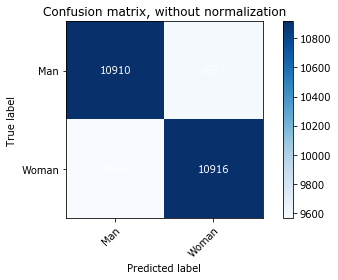

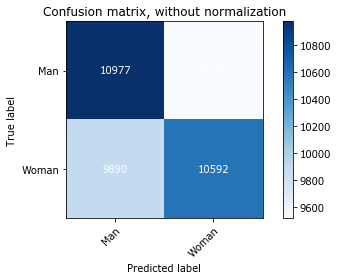

In [53]:
# training
models_and_scores = []
sss = StratifiedShuffleSplit(n_splits=NB_CV_SPLITS, test_size=TEST_SIZE)
start_time = time.time()
for id, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f'Split {id+1}/{NB_CV_SPLITS}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # plot training data with t-SNE
    if PLOT_TRAINING_DATA:
        plot_data(X_train, y_train)
    
    # scale
    if SCALER is not None:
        X_train, X_test = scale_data(SCALER, X_train, X_test)
    
    # fit and predict a model
    models_and_scores.append(train_model(CLASSIFIER, X_train, y_train, X_test, y_test, PARAMS[CLASSIFIER]))
print(f'Time to train the classifier: {round((time.time()-start_time)/60, 1)} m')

In [56]:
# metrics
if not isinstance(models_and_scores, pd.DataFrame):
    models_and_scores = pd.DataFrame(models_and_scores, columns=['Model', 'Scores'])
    models_and_scores['Accuracy'] = models_and_scores['Scores'].apply(lambda scores: scores[0])
    models_and_scores['Precision'] = models_and_scores['Scores'].apply(lambda scores: scores[1])
    models_and_scores['Recall'] = models_and_scores['Scores'].apply(lambda scores: scores[2])
    models_and_scores = models_and_scores.drop('Scores', axis='columns')

print('Mean accuracy: {:.3f}'.format(models_and_scores["Accuracy"].mean()))

Mean accuracy: 0.5294785133849045
